# Object counting using k-connected components #


Blood cells detection - summary:

1. blood_cells.jpg (nienakładające się krwinki) - 167 objects, time 0:00:28.844000
2. red_blood_cells.png (nakładające się krwinki) - 193 objects, time 0:00:17.422000

additional parameters - none

## 1. Import of modules##

In [1]:
from PIL import Image
from skimage import io, filters,measure
import cv2
import numpy as np
import networkx as nx
from graphviz import Graph
from networkx.algorithms import approximation as apxa
from random import randint,random
import matplotlib.pyplot as plt
import glob, os
from datetime import timedelta
import time

## 2. Transformation an image into a graph ##

In [2]:
def define_nodes(graph, shape):
    for i in range(shape[0]):
        for j in range(shape[1]):
            graph.add_node((i, j)) 

In [3]:
def define_edges(graph, channel, shape):
    for i in range(shape[1]):
        for j in range(shape[0]):
            if i - 1 >= 0 and channel[i][j] == channel[i-1][j]:
                graph.add_edge((i, j), (i-1, j), weight=channel[i][j])
            if j - 1 >= 0 and channel[i][j] == channel[i][j-1]:
                graph.add_edge((i, j), (i, j-1), weight=channel[i][j])

## 3. Visualization of the effects of segmentation  ##

In [4]:
def get_result_channel_random(channel, two_connected_components):

    result = np.full(channel.shape, 255)

    random_color = lambda: int(random()*255)
    colors = [random_color() for i in range(len(two_connected_components))]
    i=0
    for component in two_connected_components:
        for pair in component:
            result[pair[0]][pair[1]] = colors[i]
        i+=1     
    return result

## 4. Blood cells counting

In [5]:
def two_connected_pipeline_binary(image):
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        cv2.drawContours(thresh,[cnt],0,255,-1)
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN, kernel,iterations=2)
    image = Image.fromarray(opening)

    scale_percent = 100 
    if(opening.shape[1]>700 or opening.shape[0]>700):
        scale_percent = 70 
    width = int(opening.shape[1] * scale_percent / 100)
    height = int(opening.shape[0] * scale_percent / 100)
    shape= (width, height)    
    image = image.resize(shape)
   
    image_arr = np.array(image, dtype='int16')
    
    graph1 = nx.Graph()
    define_nodes(graph1, shape)
    define_edges(graph1, image_arr, shape)
    
    k_components = apxa.k_components(graph1)
    two_connected_components = k_components[2]
    
    print(len(two_connected_components))
    
    result = get_result_channel_random(image_arr, two_connected_components)
    result = np.array(result, dtype='int16')
    plt.imshow(result)
    plt.show()

Image 1

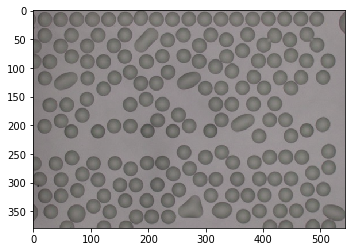

167


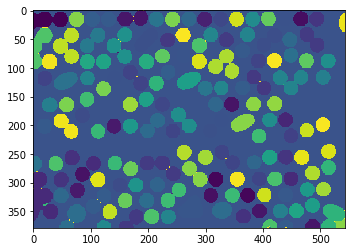

0:00:28.844000


In [6]:
img = cv2.imread('blood_cells.jpg')
plt.imshow(img)
plt.show()

start_time = time.monotonic()
two_connected_pipeline_binary(img)
end_time = time.monotonic()
print(timedelta(seconds = end_time - start_time))

Image 2

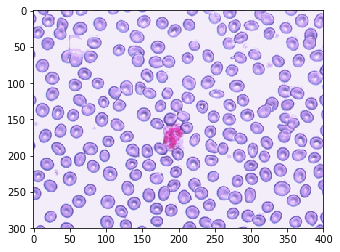

193


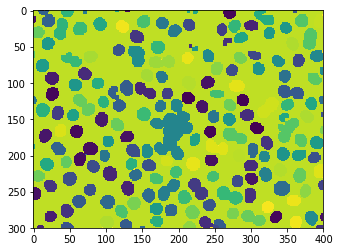

0:00:17.422000


In [7]:
img = cv2.imread('red_blood_cells.png')
plt.imshow(img)
plt.show()

start_time = time.monotonic()
two_connected_pipeline_binary(img)
end_time = time.monotonic()
print(timedelta(seconds = end_time - start_time))

## 5. Bees counting ##

In [8]:
def two_connected_pipeline_binary_bees(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        cv2.drawContours(thresh,[cnt],0,255,-1)
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN, kernel,iterations=2)
    new_im = Image.fromarray(opening)
    
    scale_percent = 100 
    if(image.shape[1]>700 or image.shape[0]>700):
        scale_percent = 70 
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    shape= (width, height)    
    image = new_im.resize(shape)
   
    image_arr = np.array(image, dtype='int16')
    
    graph1 = nx.Graph()
    define_nodes(graph1, shape)
    define_edges(graph1, image_arr, shape)
    
    k_components = apxa.k_components(graph1)
    two_connected_components = k_components[2]
    
    volumes = []
    for comp in two_connected_components:
        volumes.append(len(comp))
  
    quant_1=np.quantile(volumes,0.25,axis=0)
    quant_3=np.quantile(volumes,0.75,axis=0)
    k=1.5
    t_down=quant_1-k*(quant_3-quant_1)
    t_up=quant_3+k*(quant_3-quant_1)

    big_comp=[]
    small_comp=[]
    for i in range(len(volumes)):
        if volumes[i]>t_up:
            big_comp.append(i)
        if volumes[i]<t_down:
            small_comp.append(i)
    normal_comp = [item for item in range(0,len(volumes)) if item not in small_comp and item not in big_comp]
    print(len(normal_comp))
    result = np.full((shape[1],shape[0]), 255)
    random_color = lambda: int(random()*255)
    colors = [random_color() for i in range(len(two_connected_components))]
    i=0
    for component in two_connected_components:
        if i in normal_comp:
            for pair in component:
                result[pair[0]][pair[1]] = colors[i]
        i+=1     
    result = np.array(result, dtype='int16')
    plt.imshow(result)

In [9]:
DIR = 'C:/Users/Patrycja/Desktop/Projekt ABB/github/'

chosen_frames = []
os.chdir(DIR + "chosen_frames")
for file in glob.glob("*.jpg"):
    chosen_frames.append(Image.open(file))  
    
frames = []
for fi in chosen_frames:
    w, h = fi.size
    frames.append(fi.crop((0, 240, 500, h-50)))

Image 1

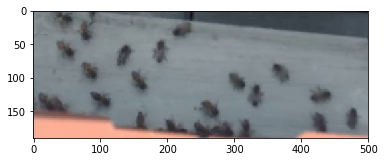

19


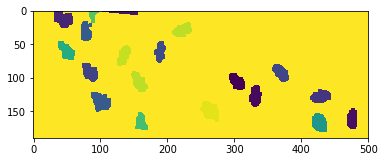

In [10]:
bees = frames[0]
plt.imshow(bees)
plt.show()

bees = cv2.cvtColor(np.array(bees), cv2.COLOR_RGB2BGR)

two_connected_pipeline_binary_bees(bees)

Image 2

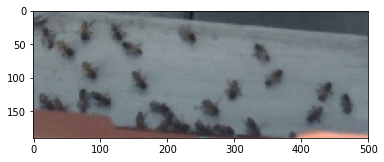

15


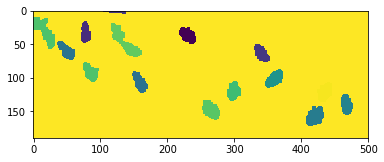

In [11]:
bees = frames[1]
plt.imshow(bees)
plt.show()
bees = cv2.cvtColor(np.array(bees), cv2.COLOR_RGB2BGR)

two_connected_pipeline_binary_bees(bees)

Image 3

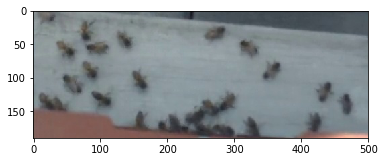

15


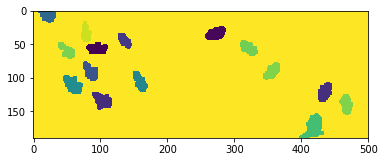

In [12]:
bees = frames[2]
plt.imshow(bees)
plt.show()
bees = cv2.cvtColor(np.array(bees), cv2.COLOR_RGB2BGR)

two_connected_pipeline_binary_bees(bees)